### **Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yfin

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

### **Gathering the Data**
We prepare 10 years of data for the model to train on

In [2]:
# company ticker name
# example ticker names for testing
# AAPL = Apple, NVDA = NVidia, F = Ford, SPY = SPDR S&P 500, MSFT = Microsoft
# simply change the company ticker name below to test that stock
company = 'AAPL'

# specify training data timeline: 10 years
# from 2010 to 2020

#start = dt.datetime(2010,1,1)
#end = dt.datetime(2020,1,1)

start = '2010-1-1'
end = '2020-1-1'

yfin.pdr_override()

data = pdr.get_data_yahoo(company, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:

print(data)

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2010-01-04   7.622500   7.660714   7.585000   7.643214   6.496294  493729600
2010-01-05   7.664286   7.699643   7.616071   7.656429   6.507526  601904800
2010-01-06   7.656429   7.686786   7.526786   7.534643   6.404016  552160000
2010-01-07   7.562500   7.571429   7.466071   7.520714   6.392177  477131200
2010-01-08   7.510714   7.571429   7.466429   7.570714   6.434672  447610800
...               ...        ...        ...        ...        ...        ...
2019-12-24  71.172501  71.222504  70.730003  71.067497  69.421059   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.798409   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.771538  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  71.191574  144114400
2019-12-31  72.482498  73.419998  72.379997  73.412498  71.711739  100805600

### **Preprocessing the Data**
The time frame is a day

The model is looking back at the last 90 days

The model is using only the 'Close' price as a univariate input

In [4]:
# scaler will process the data to fit in a value between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# we are only using closing price data to make the prediction
# so we will only be scaling the closing price
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# here we are specifying how many days in the past do we want to look back into
# in order to make the prediction in this case we are looking back 90 days
prediction_days = 90

# empty lists for training data
x_train = []
y_train = []

# we start at 90 days until the length of the scaled data which is 10 years
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days: x, 0])   #  adding value to x_train 90 days of labeled data with values
    y_train.append(scaled_data[x, 0])   # adding the 91st value

# converting to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# we reshape for the LSTM to work with
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### **Building the LSTM Model**
The model will be predicting the price

In [5]:
model = Sequential()

# here we specify the layers
# LSTM layers should always be accompanied by a dropout layer
# Dropout layer randomly sets input units to 0 with a frequency rate of 0.2 to prevent overfitting during training
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # units = dimesionality/layers
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))   # the Output prediction of the  price

# we then compile the model
model.compile(optimizer='Adam', loss='mean_squared_error')

# we now try for fit the model to the training data
# epoch is the number of times you go through the training set
# batch_size slices the data into batches of 32
history = model.fit(x_train, y_train, epochs=25, batch_size=32)

Metal device set to: Apple M1 Max


2023-08-04 21:33:59.881799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-04 21:33:59.882201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/25


2023-08-04 21:34:00.404928: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 21:34:01.968757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:34:02.226357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:34:03.162670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:34:03.370728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:34:03.749189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:34:04.855932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

76/76 [==============================] - 12s 86ms/step - loss: 0.0096
Epoch 2/25
76/76 [==============================] - 5s 68ms/step - loss: 0.0011
Epoch 3/25
76/76 [==============================] - 5s 68ms/step - loss: 7.0896e-04
Epoch 4/25
76/76 [==============================] - 5s 68ms/step - loss: 6.9057e-04
Epoch 5/25
76/76 [==============================] - 5s 68ms/step - loss: 5.1091e-04
Epoch 6/25
76/76 [==============================] - 5s 67ms/step - loss: 4.4835e-04
Epoch 7/25
76/76 [==============================] - 5s 68ms/step - loss: 4.5838e-04
Epoch 8/25
76/76 [==============================] - 5s 67ms/step - loss: 4.7984e-04
Epoch 9/25
76/76 [==============================] - 5s 68ms/step - loss: 4.9295e-04
Epoch 10/25
76/76 [==============================] - 5s 71ms/step - loss: 4.9765e-04
Epoch 11/25
76/76 [==============================] - 5s 68ms/step - loss: 3.7458e-04
Epoch 12/25
76/76 [==============================] - 5s 68ms/step - loss: 3.3428e-04
Epoch 1

### **Plotting the loss function during training**

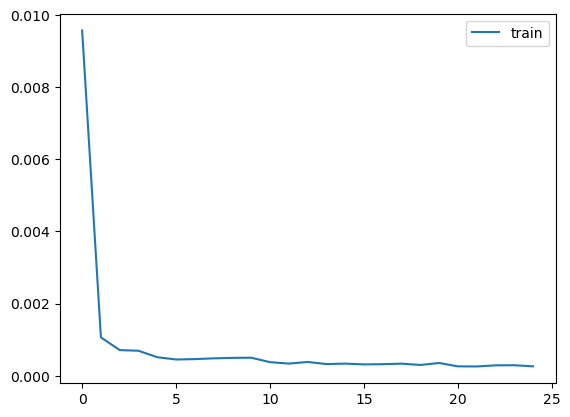

In [6]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### **Testing the Model on Existing Data**
We test the model on data that the model has not seen before

In [8]:
# this needs to be data that the model has not seen before
# we select a start and end date that is much later that our training data timeline
# here we are using a test set of 3 months
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime(2020,5,1)

#test_data = web.DataReader(company, 'yahoo', test_start, test_end)
test_data = pdr.get_data_yahoo(company, test_start, test_end)

# we need to concatenate a full data set on the data that we need to predict on
actual_prices = test_data['Close'].values

# concatenating data and test data
total_dataset = pd.concat((data['Close'], test_data['Close']))

# what our model will see as an input so it can predict the next price.
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# reshaping and scaling the model inputs
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [9]:
print(type(actual_prices))


for i in actual_prices:
  print(i)

print(type(total_dataset))
print(type(model_inputs))
print(model_inputs)

<class 'numpy.ndarray'>
75.0875015258789
74.35749816894531
74.94999694824219
74.59750366210938
75.79750061035156
77.40750122070312
77.5824966430664
79.23999786376953
78.16999816894531
77.83499908447266
78.80999755859375
79.68250274658203
79.14250183105469
79.42500305175781
79.80750274658203
79.57749938964844
77.23750305175781
79.42250061035156
81.08499908447266
80.96749877929688
77.37750244140625
77.16500091552734
79.7125015258789
80.36250305175781
81.30249786376953
80.00749969482422
80.38749694824219
79.90249633789062
81.80000305175781
81.21749877929688
81.23750305175781
79.75
80.90499877929688
80.07499694824219
78.26249694824219
74.54499816894531
72.0199966430664
73.1624984741211
68.37999725341797
68.33999633789062
74.70249938964844
72.33000183105469
75.68499755859375
73.2300033569336
72.25749969482422
66.5425033569336
71.33499908447266
68.85749816894531
62.057498931884766
69.49250030517578
60.5525016784668
63.21500015258789
61.66749954223633
61.19499969482422
57.310001373291016
56.0

### **Evaluating How Accurate Our Model Performs**

In [10]:
# make  predictions on test data
# empty list for our test
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days: x, 0])

# transforming into a numpy array
x_test = np.array(x_test)

# we reshape for the LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict based on  the x_test data
prediction_prices = model.predict(x_test)

# since the predicted prices are scaled we need to inverse transform them back to the actual predicted prices
prediction_prices = scaler.inverse_transform(prediction_prices)


2023-08-04 21:49:37.964538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:49:38.046716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:49:38.213089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-04 21:49:38.382824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 286ms/step


In [11]:
print(model_inputs)

[[0.65813256]
 [0.67259461]
 [0.66384226]
 [0.66898847]
 [0.68206063]
 [0.68104645]
 [0.66962705]
 [0.68273681]
 [0.69810036]
 [0.69802521]
 [0.70144353]
 [0.71094714]
 [0.73682855]
 [0.73495036]
 [0.71864772]
 [0.72296753]
 [0.72597263]
 [0.73374835]
 [0.72694933]
 [0.7148162 ]
 [0.71853503]
 [0.71462837]
 [0.72721224]
 [0.72292998]
 [0.71891069]
 [0.73825599]
 [0.74058492]
 [0.71943658]
 [0.72642344]
 [0.74967534]
 [0.74986317]
 [0.7398712 ]
 [0.74975048]
 [0.76124497]
 [0.78423401]
 [0.7829568 ]
 [0.78089084]
 [0.77732224]
 [0.78074055]
 [0.78498527]
 [0.80038637]
 [0.79832041]
 [0.81041587]
 [0.81191846]
 [0.82318757]
 [0.83246582]
 [0.81082908]
 [0.81071639]
 [0.83137644]
 [0.85789648]
 [0.86420716]
 [0.86281732]
 [0.86323046]
 [0.87145693]
 [0.87412403]
 [0.88186215]
 [0.88096055]
 [0.89038908]
 [0.88351497]
 [0.89523483]
 [0.90026836]
 [0.8972257 ]
 [0.88558092]
 [0.88114843]
 [0.88028443]
 [0.89752616]
 [0.88971296]
 [0.90304803]
 [0.90083179]
 [0.88922461]
 [0.87153213]
 [0.88

### **Plotting the Test Predictions**

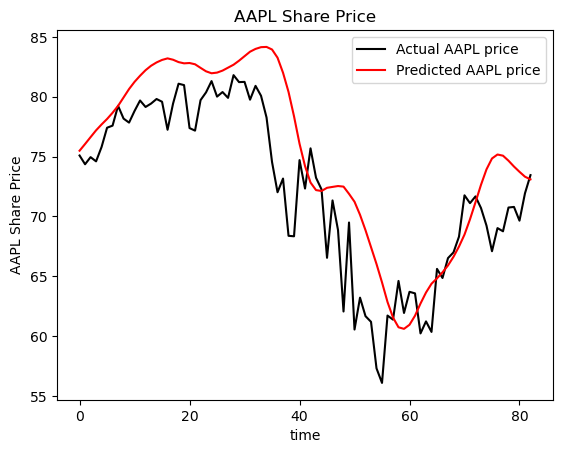

In [12]:
# black for actual
# green for prediction
plt.plot(actual_prices, color='black', label=f"Actual {company} price")
plt.plot(prediction_prices, color='red', label=f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()